In [1]:
import tensorflow as tf

def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

select_gpu(2)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [2]:
import re

In [3]:
sequence_length = 128
epochs = 10
model_name = 'bert-chinese'

In [4]:
def txt_to_list(path, sequence_length):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
#         text_list = [i for i in text]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
#                 print(entity)            
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
        
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
#             while len(sentence) < sequence_length:
#                 sentence += 'O'
#             if len(sentence) > sequence_length:
#                 sentence = sentence[:sequence_length]
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
#                 while len(tmp) < sequence_length:
#                     tmp.append('O')
#                 if len(tmp) > sequence_length:
#                     tmp = tmp[:sequence_length]
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [5]:
x1, y1 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt', sequence_length)

In [6]:
x2, y2 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt', sequence_length)

In [7]:
x4, y4 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt', sequence_length)

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
embed_path = '/home/Danny/pretrain_model/{}'.format(model_name)
bert_embed = BertEmbedding(embed_path, sequence_length=sequence_length)
model = BiLSTM_CRF_Model(bert_embed)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
                   )

2020-12-03 00:56:03,180 [DEBUG] kashgari - ------------------------------------------------
2020-12-03 00:56:03,180 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-03 00:56:03,181 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-03 00:56:03,181 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-03 00:56:03,181 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-03 00:56:03,182 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/10
191/191 [==============================] - 42s 221ms/step - loss: 0.7902 - accuracy: 0.9644 - val_loss: 25.7261 - val_accuracy: 0.9848
Epoch 2/10
191/191 [==============================] - 39s 206ms/step - loss: 0.2301 - accuracy: 0.9855 - val_loss: 25.5278 - val_accuracy: 0.9884
Epoch 3/10
191/191 [==============================] - 39s 206ms/step - loss: 0.1743 - accuracy: 0.9882 - val_loss: 25.3116 - val_accuracy: 0.9885
Epoch 4/10
191/191 [==============================] - 39s 207ms/step - loss: 0.1446 - accuracy: 0.9895 - val_loss: 25.1071 - val_accuracy: 0.9902
Epoch 5/10
191/191 [==============================] - 40s 207ms/step - loss: 0.1241 - accuracy: 0.9905 - val_loss: 24.9253 - val_accuracy: 0.9866
Epoch 6/10
191/191 [==============================] - 40s 208ms/step - loss: 0.1053 - accuracy: 0.9914 - val_loss: 24.7466 - val_accuracy: 0.9878
Epoch 7/10
191/191 [==============================] - 40s 208ms/step - loss: 0.0925 - accuracy: 0.9924 - val_loss: 24.5345 -

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-03 01:02:59,420 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-03 01:02:59,520 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 43s 91ms/step


2020-12-03 01:03:46,817 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-03 01:03:46,818 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8018    0.7535    0.7769       848
      med_exam     0.8467    0.8286    0.8375       140
          name     0.9048    0.7600    0.8261       100
      location     0.9268    0.8352    0.8786        91
    profession     0.5000    0.2222    0.3077         9
         money     0.6721    0.7885    0.7257        52
       contact     0.8889    0.6154    0.7273        13
        family     0.7000    0.4118    0.5185        17
            ID     0.8000    0.5000    0.6154         8
clinical_event     0.0000    0.0000    0.0000         4
  organization     0.0000    0.0000    0.0000         3
     education     0.0000    0.0000    0.0000         1

     micro avg     0.8150    0.7535    0.7830      1286
     macro avg     0.8107    0.7535    0.7794      1286



2020-12-03 01:03:55,872 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10'

In [12]:
from matplotlib import pyplot as plt

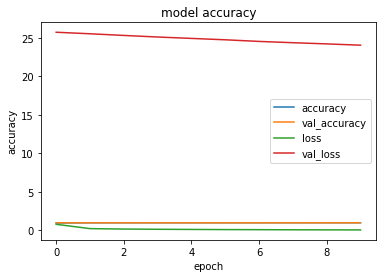

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [14]:
import pandas as pd
df = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.csv')
df

,Unnamed: 0,article_id,text
0,0,0,醫師：這個要電腦看才有辦法，這是嚴重或一般的。民眾：這是沒關係啦。醫師：沒關係齁。民眾：他一...
1,1,1,醫師：就照舊這樣子。阿這一定要跟你講一下。家屬：沒關係啊。醫師：阿最近好嗎？民眾：都正常。醫...
2,2,2,醫師：就照這樣，我們就照這樣問診這樣而已啦，阿最近我們8月17號有抽血。家屬：對上上個禮拜。...
3,3,3,醫師：最近有怎麼樣嗎？民眾：都一樣欸。醫師：會痛還是怎麼樣嗎？民眾：都一樣。醫師：有發燒或是...
4,4,4,民眾：前一次是6月14號。醫師：嗯，14。民眾：13還是14。醫師：我看一下14啊，13和1...
...,...,...,...
65,65,65,個管師：來坐這裡。民眾：好，坐這裡嗎？好，靠你那麼近？個管師：靠我近一點好啊，不好嗎？會讓你...
66,66,66,個管師：好喘……哈哈哈哈。民眾：哈哈。個管師：好。小明這個月還好嗎？民眾：很好啊。個管師：很...
67,67,67,個管師：所以你是去篩檢的時候……民眾：恩。個管師：你去篩檢的時候然後許小姐跟你說你可以來這邊...
68,68,68,個管師：好喔，過去這一個月還好嗎？民眾：恩，還可以。個管師：那今天是請假？民眾：沒有，晚上上...


In [21]:
def predict_NER(model, text, sequence_length):
    x_list = list()
    while len(text) > sequence_length:
        x_list.append([i for i in text[:sequence_length]])
        text = text[sequence_length:]        
    x_list.append([i for i in text[:sequence_length]])
    y_list = model.predict(x_list)
    for i, j in zip(x_list, y_list):
    merge_list = list()
    for i in y_list:
        for j in i:
            merge_list.append(j)
    return merge_list

IndentationError: expected an indented block (<ipython-input-21-fd2b14f31c9e>, line 9)

In [22]:
def output_NER(article_id, text, y):
    output = str()
    flag = False
    for i, j in enumerate(y):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
    return output

In [ ]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for article_id, text in zip(df['article_id'], df['text']):
    y = predict_NER(model, text, sequence_length)
    output += output_NER(article_id, text, y)

2020-12-03 01:07:39,348 [DEBUG] kashgari - predict seq_length: None, input: (2, 27, 130)


1/1 [==============================] - 0s 821us/step


2020-12-03 01:07:39,526 [DEBUG] kashgari - predict output: (27, 130)
2020-12-03 01:07:39,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:39,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 7, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
45 45
1/1 [==============================] - 0s 804us/step


2020-12-03 01:07:39,629 [DEBUG] kashgari - predict output: (7, 130)
2020-12-03 01:07:39,632 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1 10  7  7  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
128 128
128 128
32 32
1/1 [==============================] - 0s 598us/step


2020-12-03 01:07:39,743 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 01:07:39,743 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:39,747 [DEBUG] kashgari - predict seq_length: None, input: (2, 26, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
74 74
1/1 [==============================] - 0s 753us/step


2020-12-03 01:07:39,903 [DEBUG] kashgari - predict output: (26, 130)
2020-12-03 01:07:39,904 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:39,906 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
91 91
1/1 [==============================] - 0s 931us/step


2020-12-03 01:07:40,047 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 01:07:40,048 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,054 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
84 84
1/1 [==============================] - 0s 765us/step


2020-12-03 01:07:40,204 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 01:07:40,204 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,207 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
40 40
1/1 [==============================] - 0s 780us/step


2020-12-03 01:07:40,321 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 01:07:40,321 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,324 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
110 110
1/1 [==============================] - 0s 792us/step


2020-12-03 01:07:40,439 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 01:07:40,439 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,442 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
92 92
1/1 [==============================] - 0s 679us/step


2020-12-03 01:07:40,538 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 01:07:40,539 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 8 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,541 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
64 64
1/1 [==============================] - 0s 769us/step


2020-12-03 01:07:40,634 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 01:07:40,637 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
128 128
120 120
1/1 [==============================] - 0s 821us/step


2020-12-03 01:07:40,734 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 01:07:40,736 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  10  7  1  1  1  1  1 10  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   6  4  4  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
44 44
1/1 [==============================] - 0s 889us/step


2020-12-03 01:07:40,877 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 01:07:40,877 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,880 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
60 60
1/1 [==============================] - 0s 711us/step


2020-12-03 01:07:40,975 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 01:07:40,976 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:40,978 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
59 59
1/1 [==============================] - 0s 724us/step


2020-12-03 01:07:41,086 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 01:07:41,086 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 10  7  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 01:07:41,089 [DEBUG] kashgari - predict seq_length: None, input: (2, 11, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
31 31
1/1 [==============================] - 0s 456us/step


2020-12-03 01:07:41,198 [DEBUG] kashgari - predict output: (11, 130)
2020-12-03 01:07:41,199 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 4 4 4]]
2020-12-03 01:07:41,202 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
124 124
1/1 [==============================] - 0s 731us/step


2020-12-03 01:07:41,328 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 01:07:41,328 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:41,330 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
6 6
1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:41,431 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 01:07:41,433 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
128 128
83 83
1/1 [==============================] - 0s 767us/step


2020-12-03 01:07:41,586 [DEBUG] kashgari - predict output: (25, 130)
2020-12-03 01:07:41,587 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:41,589 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
82 82
1/1 [==============================] - 0s 713us/step


2020-12-03 01:07:41,679 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 01:07:41,681 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4
   4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
128 128
15 15
2/2 [==============================] - 0s 52ms/step


2020-12-03 01:07:41,968 [DEBUG] kashgari - predict output: (48, 130)
2020-12-03 01:07:41,969 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:41,978 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
49 49
2/2 [==============================] - 0s 35ms/step


2020-12-03 01:07:42,222 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 01:07:42,222 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:42,229 [DEBUG] kashgari - predict seq_length: None, input: (2, 28, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
57 57
1/1 [==============================] - 0s 955us/step


2020-12-03 01:07:42,392 [DEBUG] kashgari - predict output: (28, 130)
2020-12-03 01:07:42,393 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 12  9  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 01:07:42,399 [DEBUG] kashgari - predict seq_length: None, input: (2, 31, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
38 38
1/1 [==============================] - 0s 2ms/step


2020-12-03 01:07:42,583 [DEBUG] kashgari - predict output: (31, 130)
2020-12-03 01:07:42,584 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128


2020-12-03 01:07:42,590 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
93 93
1/1 [==============================] - 0s 991us/step


2020-12-03 01:07:42,712 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 01:07:42,713 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:42,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
81 81
1/1 [==============================] - 0s 872us/step


2020-12-03 01:07:42,822 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 01:07:42,823 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:42,824 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
23 23
1/1 [==============================] - 0s 908us/step


2020-12-03 01:07:42,926 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 01:07:42,927 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:42,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
118 118
1/1 [==============================] - 0s 890us/step


2020-12-03 01:07:43,073 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 01:07:43,074 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 5, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
32 32
1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:43,169 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 01:07:43,171 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1 12  9  6  4  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
125 125
1/1 [==============================] - 0s 806us/step


2020-12-03 01:07:43,316 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 01:07:43,317 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,320 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
94 94
1/1 [==============================] - 0s 729us/step


2020-12-03 01:07:43,468 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 01:07:43,469 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,474 [DEBUG] kashgari - predict seq_length: None, input: (2, 14, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
22 22
1/1 [==============================] - 0s 724us/step


2020-12-03 01:07:43,593 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 01:07:43,593 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,598 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
18 18
1/1 [==============================] - 0s 908us/step


2020-12-03 01:07:43,732 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 01:07:43,732 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,737 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
99 99
1/1 [==============================] - 0s 848us/step


2020-12-03 01:07:43,895 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 01:07:43,896 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:43,899 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
32 32
1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:44,015 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 01:07:44,016 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:44,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
82 82
2/2 [==============================] - 0s 37ms/step


2020-12-03 01:07:44,293 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 01:07:44,294 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:44,300 [DEBUG] kashgari - predict seq_length: None, input: (2, 40, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
8 8
2/2 [==============================] - 0s 42ms/step


2020-12-03 01:07:44,576 [DEBUG] kashgari - predict output: (40, 130)
2020-12-03 01:07:44,577 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 11  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 01:07:44,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
121 121
1/1 [==============================] - 0s 747us/step


2020-12-03 01:07:44,695 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 01:07:44,696 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:44,699 [DEBUG] kashgari - predict seq_length: None, input: (2, 12, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
11 11
1/1 [==============================] - 0s 811us/step


2020-12-03 01:07:44,819 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 01:07:44,820 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:44,822 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
52 52
1/1 [==============================] - 0s 2ms/step


2020-12-03 01:07:45,014 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 01:07:45,021 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12
   9  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1 12  9  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  6  1  1  6  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

128 128
128 128
128 128
128 128
128 128
75 75


2020-12-03 01:07:45,024 [DEBUG] kashgari - predict seq_length: None, input: (2, 18, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:45,227 [DEBUG] kashgari - predict output: (18, 130)
2020-12-03 01:07:45,229 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:45,232 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
58 58
1/1 [==============================] - 0s 3ms/step


2020-12-03 01:07:45,457 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 01:07:45,458 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:45,465 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
11 11
1/1 [==============================] - 0s 906us/step


2020-12-03 01:07:45,674 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 01:07:45,675 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:45,683 [DEBUG] kashgari - predict seq_length: None, input: (2, 24, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
123 123
1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:45,892 [DEBUG] kashgari - predict output: (24, 130)
2020-12-03 01:07:45,893 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:45,899 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
41 41
1/1 [==============================] - 0s 1ms/step


2020-12-03 01:07:46,054 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 01:07:46,056 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 01:07:46,060 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
115 115
1/1 [==============================] - 0s 4ms/step


2020-12-03 01:07:46,219 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 01:07:46,221 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 12  9  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 01:07:46,224 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
10 10
1/1 [==============================] - 0s 674us/step


2020-12-03 01:07:46,377 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 01:07:46,378 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 6 ... 1 1 1]]
2020-12-03 01:07:46,386 [DEBUG] kashgari - predict seq_length: None, input: (2, 43, 130)


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
118 118
1/2 [==============>...............] - ETA: 0s

In [19]:
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	256	258	25	time
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	409	411	4點	time
0	424	427	一小時	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	817	819	晚上	time
0	836	838	那天	time
0	1168	1172	7月21	time
0	1571	1574	10多	time
0	1809	1812	10多	time
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2226	2228	3天	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2767	2770	皇后區	location
0	2774	2777	皇后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	2859	2862	1小時	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	85	88	110	med_exam
2	111	114	6.0	med_exam
2	279	282	2年前	time
2	563	566	光華路	location
2	571	574	光華路	location
2	980

In [20]:
output_path='output/{}_epo_{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output)